# 프로젝트: 인물 모드 문제점 찾기

## Step 1. 인물모드 직접 해 보기

In [5]:
import os
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from pixellib.semantic import semantic_segmentation

In [10]:
def load_model():
    # 모델 받아오기
    model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    
    # 다운로드를 시작합니다
    if not os.path.exists(model_file):
        urllib.request.urlretrieve(model_url, model_file)  # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장
    
        # 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
        model = semantic_segmentation()
        model.load_pascalvoc_model(model_file)
    
    return model
model = load_model()

In [19]:
def blur_image(img_path, model):
    # 모델에 이미지를 입력 => 이미지 분할 수행
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    plt.imshow(output)
    plt.show()
    
    # 원본 이미지 로드
    img_orig = cv2.imread(img_path)
    
    # 컬러맵 만들기 
    # 물체마다 output에 어떤 색상으로 나타나 있는지 알아내는 코드
    seg_color = (128, 128, 192)
    seg_map = np.all(output == seg_color, axis=-1)
    
    plt.imshow(seg_map, cmap='gray')  # cmap = 'gray' ==> 흑백으로 출력(Accent, summer 등등 많음)
    plt.show()
    
    # 마스크 생성
    # True(사람, 1 -> 255) False(배경, 0->0)
    img_mask = seg_map.astype(np.uint8) * 255
    # 이미지 색상 채널 변경 (BGR -> RGB)
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    # cv2.bitwise_not(): 이미지가 반전됩니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    
    # 블러 처리
    # 블러처리된 이미지 생성
    # (13,13)은 blurring kernel size를 뜻합니다
    img_orig_blur = cv2.blur(img_orig, (13, 13))
    # 반전된 이미지(배경 255)에 블러 씌우기
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # np.where(조건, 참일때, 거짓일때)
    # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오기
    # 아닌 영역은 블러된 이미지 값을 사용합니다.  
    img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

    # 결과 출력
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
# 사용 예시
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_image.png'
blur_image(img_path, model)

---
## Step 2. 사진에서 문제점 찾기

뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나옴

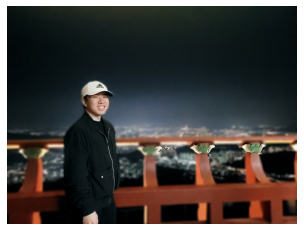

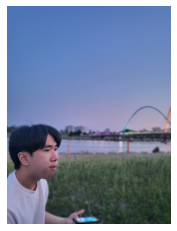

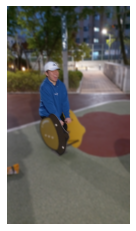

In [7]:
img_path1 = 'images/1.jpg'
img_path2 = 'images/2.jpg'
img_path3 = 'images/3.jpg'
blur_image(img_path1, model)
blur_image(img_path2, model)
blur_image(img_path3, model)

---
## Step 3. 해결 방법을 제안해 보기

세 사진 모두 하나도 초점이 안잡히는 느낌이다....
jpg파일이라?

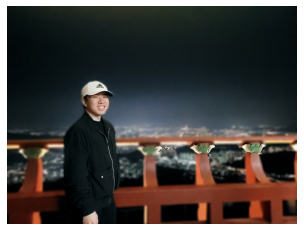

In [14]:
img_path1_png = 'images/1-1.png'
blur_image(img_path1_png, model)

이것도 아님

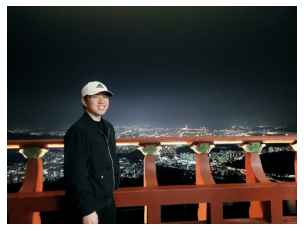

In [16]:
# 원본 이미지 출력
img1 = cv2.imread(img_path1_1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

이미지 불러올 때부터 피사체에 흐릿한 느낌이 있다..그냥 과정을 한번 살펴보자

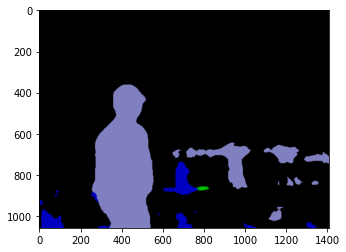

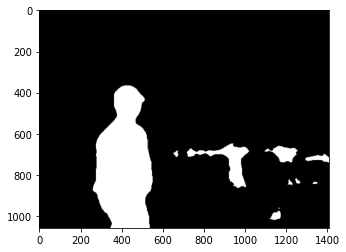

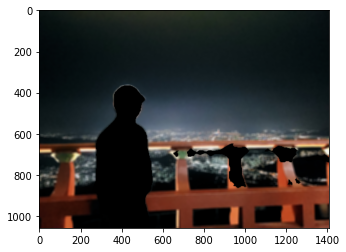

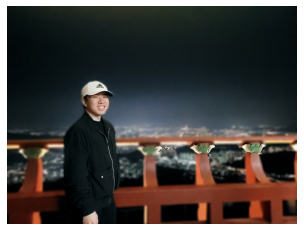

In [20]:
img_path1_png = 'images/1-1.png'
blur_image(img_path1_png, model)

1. 피사체는 잘 잡는 것을 확인 =>만 다른 엉뚱한 기둥까지 피사체로 잡힌 것을 확인  
2. 잘 구분했음에도 피사체가 흐릿하게 보임 => 입력할 때 이미지 해상도가 망가지는듯

모델이나 한번 바꿔써보자

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from transformers import AutoModelForImageSegmentation

model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.to('cuda')
model.eval()

AttributeError: module 'torch' has no attribute '_utils_internal'

In [26]:
# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 로드
model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.to(device)
model.eval()

# 이미지 경로 설정
input_image_path = '/content/drive/MyDrive/image_self.jpg'

NameError: name 'AutoModelForImageSegmentation' is not defined

In [30]:
import torch
import torchvision

print(torch.__version__)  # PyTorch 버전 확인
print(torchvision.__version__)  # torchvision 버전 확인

AttributeError: module 'torch' has no attribute '_utils_internal'